In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
from natsort import natsorted
from myusefultools.parser import pickleVolScalarField

# Water flux over the dune lenght

Plot $\phi_\mathtt{water}$ over the dune lenght for the LES and RANS initial condition.

In [2]:
## Dune parameters
duneHeight     = 0.015 #m
bedWavelenght  = 0.15
hydCond        = 0.00100319
depthBed       = 0.20
channelWidth   = 0.29
porosity       = 0.358
waterDepth     = 0.0975
meanVelocity   = 0.15
g = 9.81

Axy = bedWavelenght*channelWidth
shapeDune = pd.read_csv("./shapeOfDune.csv")
shapeDune.sort_values(['Points:0','Points:2'],inplace=True)
bedformWavenumber = 2*np.pi/bedWavelenght

In [3]:
# Calculate sine head distribution
exponentForHeadm = (3/8,3/2)[duneHeight/waterDepth > 0.34]
head_m  = 0.28 * meanVelocity**2 / (2*g) * np.power(duneHeight/waterDepth/0.34,exponentForHeadm)
print("h_m = {:.3E} m".format(head_m))

h_m = 2.385E-04 m


In [4]:
X = np.linspace(0,bedWavelenght,50)

## head = 0 @ x = trough
h_Packman = head_m*np.cos(bedformWavenumber*(X+0.00))
v_Packman = -bedformWavenumber*hydCond*head_m*np.sin(bedformWavenumber*(X+0.00))*np.tanh(bedformWavenumber*depthBed)

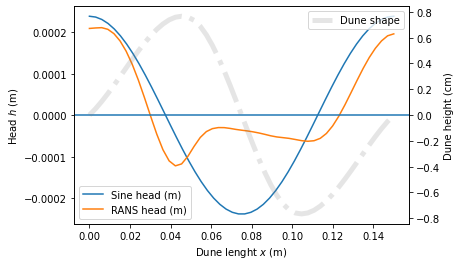

In [5]:
fig,ax = plt.subplots(sharex=True)
ax.plot(X,h_Packman,label='Sine head (m)')
ax.plot(shapeDune['Points:0'],shapeDune['h'],label='RANS head (m)')
ax.axhline(y=0)
ax.set(xlabel="Dune lenght $x$ (m)",ylabel="Head $h$ (m)")
ax.legend()
ax2=ax.twinx()
ax2.plot(shapeDune['Points:0'],shapeDune['Points:1']*100,
         c='gray',ls='-.',alpha=0.2,lw=5,label='Dune shape')
ax2.set(ylabel="Dune height (cm)")
ax2.legend()
plt.show()

In [6]:
variables=["phi","h","hMean"]

LES = pickleVolScalarField(path="/home/edsaa/nuModel/tempResults_review/noRelax_dp9.LES",variables=variables, keyword="top")
RAS = pickleVolScalarField(path="/home/edsaa/nuModel/tempResults_review/noRelax_dp9.RANS",variables=variables, keyword="top")

In [7]:
for df in [LES,RAS]:
    tempAr1,tempAr2 = [],[]
    for phi in df['phi']:
        tempAr1.append(np.minimum(phi,0))
        tempAr2.append(np.maximum(phi,0))
    df['ma.phi.in']  = tempAr1
    df['ma.phi.out'] = tempAr2

In [8]:
Axy_tile = 0.0008923 # Got it from Paraview
for df in [LES,RAS]:
    df['v.in [m/s]'] = df['ma.phi.in']/Axy_tile
    df['v.out [m/s]'] = df['ma.phi.out']/Axy_tile

In [9]:
legLab = {'LES':'Unsteady turbulent - ' + r"${Using \; p(x_j,t)}$",
          'RAS':'Time-averaged - ' + r"${Using \; \bar{p}(x_j)}$",
          'P20':'Pumping model - ' + "$\mathit{Packman\,et\,al.\,2000}$"}

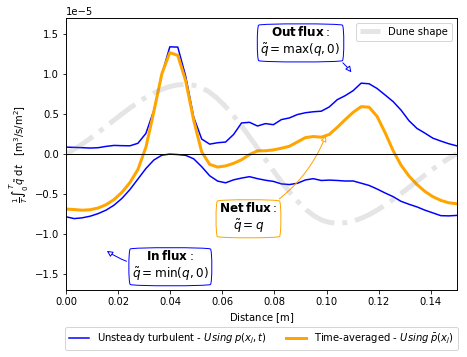

In [10]:
fig,ax = plt.subplots(figsize=[7,5])

#ax.plot(X,v_Packman)
#ax.plot(CardenasP['X']*0.15,CardenasP[' P']*head_m)

ax.plot(X,LES['v.in [m/s]'].mean(),c='b',label=legLab['LES'])
ax.plot(X,LES['v.out [m/s]'].mean(),c='b')
ax.plot(X,RAS['phi'].mean()/Axy_tile,c='orange',label=legLab['RAS'],lw=3)
ax.set(ylabel=r'$\frac{1}{T} \int_0^T{\tilde{q} \; \mathsf{d}t} \quad \mathsf{[m^3/s/m^2]}$',
       xlabel=r'$\mathsf{Distance\;[m]}$',
       xlim=[0,bedWavelenght],
       ylim=[-1.7E-5,1.7E-5])

#ax.fill_between(np.linspace(0,49,50),RAS['ma.phi.in'].mean()/Axy,facecolor='purple',alpha=0.1,label='Downwelling')
#ax.fill_between(np.linspace(0,49,50),RAS['ma.phi.out'].mean()/Axy,facecolor='g',alpha=0.1,label='Upwelling')

ax.legend(loc='upper center',bbox_to_anchor=(0.5,-0.12),ncol=2)

ann = ax.annotate(r"$\mathbf{Out \, flux}:$" + "\n" + r"$\tilde{q} = \max(q,0)$",
                  xy=(0.11, 1.0E-5), xycoords='data',
                  xytext=(0.09, 1.4E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='b'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='b'))

ann = ax.annotate(r"$\mathbf{In \, flux}:$" + "\n" + r"$\tilde{q} = \min(q,0)$",
                  xy=(0.015, -1.2E-5), xycoords='data',
                  xytext=(0.04, -1.4E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='b'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='b'))

ann = ax.annotate(r"$\mathbf{Net \, flux}:$" + "\n" + r"$\tilde{q} = q$",
                  xy=(0.10, 0.25E-5), xycoords='data',
                  xytext=(0.07, -0.8E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='orange'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.2",
                                  fc="w",ec='orange'))


ax2 = ax.twinx()
ax2.plot(shapeDune['Points:0'],shapeDune['Points:1'],
         c='gray',ls='-.',alpha=0.2,lw=5,label='Dune shape')
ax2.axhline(y=0,lw=1,zorder=2,c='k')
ax2.set(ylim=[-0.015,0.015])
ax2.get_yaxis().set_visible(False)
ax2.legend()
#plt.savefig("FluxesOverDune.svg")
plt.show()

In [11]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
netFlux = RAS['phi'].mean()/Axy_tile

In [12]:
from scipy.interpolate import interp1d
from scipy.optimize import root
f = interp1d(X,netFlux)
locations = [root(f,initguess).x[0] for initguess in [0.02,0.05,0.07,0.12]]

In [13]:
from matplotlib.patches import ArrowStyle
leftBar = ArrowStyle.BarAB(widthA=1.0, angleA=0, widthB=0.0, angleB=0)
rightBar = ArrowStyle.BarAB(widthA=0.0, angleA=0, widthB=1.0, angleB=0)

In [14]:
textDict = dict(ha='center',va='center',c='gray',
                zorder = 6,fontsize=16,
                bbox=dict(fc="w", ec="none"))

fakeLegendDict = dict(ha='left',va='center',
                zorder = 6,fontsize=12,c='gray',
                bbox=dict(fc="w", ec=colors[-1],alpha=0.5))

cotaDict = dict(textcoords='data', zorder=5,  xycoords='data',
                arrowprops=dict(arrowstyle="|-|",
                                connectionstyle="arc3,rad=-0.02",
                                fc="w",ec=colors[-1]))

cotaDictRight = dict(textcoords='data', zorder=5,  xycoords='data',
                arrowprops=dict(arrowstyle=rightBar,
                                connectionstyle="arc3,rad=-0.02",
                                fc="w",ec=colors[-1]))

cotaDictLeft = dict(textcoords='data', zorder=5,  xycoords='data',
                arrowprops=dict(arrowstyle=leftBar,
                                connectionstyle="arc3,rad=-0.02",
                                fc="w",ec=colors[-1]))

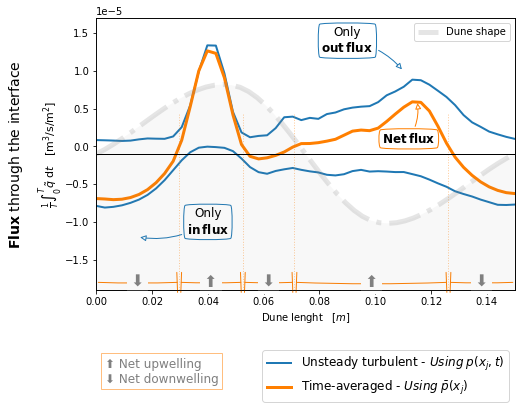

In [15]:
fig,ax = plt.subplots(figsize=[7.5,5])

ax.plot(X,LES['v.in [m/s]'].mean(),c=colors[1],label=legLab['LES'],lw=2)
ax.plot(X,LES['v.out [m/s]'].mean(),c=colors[1],lw=2)
ax.plot(X,RAS['phi'].mean()/Axy_tile,c=colors[-1],label=legLab['RAS'],lw=3)

ax.set_ylabel(r'$\frac{1}{T} \int_0^T{\tilde{q} \; \mathsf{d}t} \quad \mathsf{[m^3/s/m^2]}$',
              labelpad=0,fontsize=11)
ax.set(xlabel=r'${\rm Dune \; lenght} \quad [m]$',
       xlim=[0,bedWavelenght],
       ylim=[-1.9E-5,1.7E-5])

####################

for x in locations: ax.axvline(x=x,ymin=0,ymax=0.65,
                               lw=1,ls='dotted',zorder=2,c=colors[-1],alpha=0.4)

cotaY = -1.8E-5
ax.annotate("", xy=(0, cotaY), xytext=(locations[0], cotaY), **cotaDictLeft)
ax.annotate("", xy=(locations[0], cotaY), xytext=(locations[1], cotaY), **cotaDict)
ax.annotate("", xy=(locations[1], cotaY), xytext=(locations[2], cotaY), **cotaDict)
ax.annotate("", xy=(locations[2], cotaY), xytext=(locations[3], cotaY), **cotaDict)
ax.annotate("", xy=(locations[3], cotaY), xytext=(0.15, cotaY), **cotaDictRight)

ax.text(locations[0]/2,cotaY,"⬇️",**textDict)
ax.text((locations[0]+locations[1])/2,cotaY,"⬆️",**textDict)
ax.text((locations[1]+locations[2])/2,cotaY,"⬇️",**textDict)
ax.text((locations[2]+locations[3])/2,cotaY,"⬆️",**textDict)
ax.text((locations[3]+0.15)/2,cotaY,"⬇️",**textDict)

###################

ax2 = ax.twinx()
ax2.plot(shapeDune['Points:0'],shapeDune['Points:1'],
         c='gray',ls='-.',alpha=0.2,lw=5,label='Dune shape')
ax2.axhline(y=0,lw=1,zorder=2,c='k')
ax2.set(ylim=[-0.015,0.015])
ax2.get_yaxis().set_visible(False)
ax2.legend()
ax2.fill_between(shapeDune['Points:0'],shapeDune['Points:1'],-1,fc='gray',alpha=0.05)

###################

ann = ax.annotate("Only\n" + r"$\mathbf{out \, flux}$",# + "\n" + r"$\tilde{q} = \max(q,0)$",
                  xy=(0.11, 1.0E-5), xycoords='data',
                  xytext=(0.09, 1.4E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec=colors[1]),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec=colors[1]))

ann = ax.annotate("Only\n" + r"$\mathbf{in \, flux}$",# + "\n" + r"$\tilde{q} = \min(q,0)$",
                  xy=(0.015, -1.2E-5), xycoords='data',
                  xytext=(0.04, -1.0E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec=colors[1]),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec=colors[1]))

ann = ax.annotate(r"$\mathbf{Net \, flux}$", zorder=7,
                  xy=(0.115, 0.6E-5), xycoords='data',
                  xytext=(0.112, 0.10E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec=colors[-1]),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.2",
                                  fc="w",ec=colors[-1]))

fig.supylabel(r'$\mathbf{Flux}$ through the interface',x=-0.04,fontsize=14)

#ax.legend(loc='lower left',bbox_to_anchor=(1, 0),ncol=1,title="Obtained from:",title_fontsize=12)
ax.legend(loc='upper right',bbox_to_anchor=(1, -0.20),ncol=1,fontsize=12, title_fontsize=12)
ax.text(0.02,-0.30,"⬆️ Net upwelling\n⬇️ Net downwelling",
        transform=ax.transAxes,**fakeLegendDict)

#plt.savefig("FluxesOverDune_Pretty.svg")
plt.show()

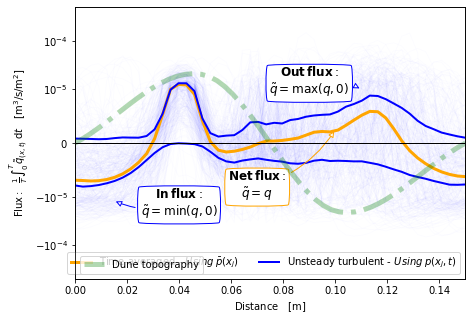

In [16]:
fig,ax = plt.subplots(figsize=[7,5])
for i in range(len(LES)):
    ax.plot(X,LES['phi'][i]/Axy_tile,alpha=0.01,lw=1,c='b')

ax.plot(X,np.mean(RAS['phi'])/Axy_tile,lw=3,c='orange',label=legLab['RAS'])
ax.plot(X,np.mean(LES['v.in [m/s]']),lw=2,c='b',label=legLab['LES'])
ax.plot(X,np.mean(LES['v.out [m/s]']),lw=2,c='b')

ax.set_yscale('symlog',linthresh=1.0E-5)
ax.set_xlim([0,bedWavelenght])
ax.set_ylim([-5.0E-4,5.0E-4])
ax.set_xlabel(r"$\mathsf{Distance \quad [m]}$")
ax.set_ylabel(r"$\mathsf{Flux:}$" + "  " +
              r'$\frac{1}{T} \int_0^T{\tilde{q}_{(x,t)} \; \mathsf{d}t} \quad \mathsf{[m^3/s/m^2]}$')
ax.legend(ncol=2,loc='lower right')

ax2 = ax.twinx()
ax2.plot(shapeDune['Points:0'],shapeDune['Points:1'],
         c='g',ls='-.',alpha=0.3,lw=5,label='Dune topography',zorder=1)
ax2.legend(loc='lower left')
ax2.get_yaxis().set_visible(False)
ax2.axhline(y=0,lw=1,zorder=2,c='k')
ax2.set(ylim=[-0.015,0.015])

ann = ax.annotate(r"$\mathbf{Out \, flux}:$" + "\n" + r"$\tilde{q} = \max(q,0)$",
                  xy=(0.11, 1.0E-5), xycoords='data',
                  xytext=(0.09, 1.4E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='b'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='b'))

ann = ax.annotate(r"$\mathbf{In \, flux}:$" + "\n" + r"$\tilde{q} = \min(q,0)$",
                  xy=(0.015, -1.2E-5), xycoords='data',
                  xytext=(0.04, -1.4E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='b'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w",ec='b'))

ann = ax.annotate(r"$\mathbf{Net \, flux}:$" + "\n" + r"$\tilde{q} = q$",
                  xy=(0.10, 0.25E-5), xycoords='data',
                  xytext=(0.07, -0.8E-5), textcoords='data',
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",ec='orange'),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.2",
                                  fc="w",ec='orange'))
#plt.savefig("FluxesOverDune_2.svg")
plt.show()